In [2]:
import numpy as np
import scipy.constants
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import datetime
import math
import h5py
import os
import CDO

from DREAM.DREAMOutput import DREAMOutput
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib.animation import FuncAnimation
from IPython import display
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.constrained_layout.use'] = True
%matplotlib ipympl

def basic_1D(figsize=[8,4], ydata=None, xdata=None, ylabel=None, xlabel=None, 
             title=None, yscale="linear", ymin=None, ymax=None, savename=None,
             plotfoldername=None):
    
    fig = plt.figure(figsize=figsize)
    plt.plot(xdata, ydata, drawstyle="steps-mid", linewidth=2)
    axes = plt.gca()
    axes.set_yscale(yscale)
    axes.set_ylim([ymin, ymax])
    axes.set_ylabel(ylabel)
    axes.set_xlabel(xlabel)
    axes.grid()
    plt.title(title)
    
    if savename:
        now = datetime.datetime.now()
        date_time = now.strftime("_%Y-%m-%d_%Hh-%Mm-%Ss")
        plt.savefig(plotfoldername + savename + date_time + ".png", dpi=150)
        
def basic_2D(figsize=[8,4], xgrid=None, ygrid=None, savename=None, 
             title=None, cbarlabel=None, plotfoldername=None,
             normalization="lin", data=None, xlabel=None, ylabel=None,
             datamin=None, datamax=None, logdiff=None, levels=None):

    data[data < 1e-10] = 1e-10
    if datamax is None:
        datamax = data.max()
        
    if datamin is None:
        datamin = data.min()

    if levels is None:
        levels = 11
        
    fig = plt.figure(figsize=figsize)
    
    if normalization == "log":
        if logdiff is None:
            ld = math.log10(datamax) - 1
            if ld > 10:
                logdiff = ld
            else:
                logdiff = 10
        
        logmax = math.ceil(np.log10(datamax))
        logmin = logmax - logdiff
        numofticks = logdiff
        div = logdiff // numofticks
        power = np.arange((logmax - (numofticks * div)), logmax, div)
        array = np.zeros(len(power)) + 10.
        ticks = np.power(array, power)
        levels1 = np.logspace(logmin, logmax, levels, base=10.0)
        formatter = matplotlib.ticker.LogFormatter(10, labelOnlyBase=False)
        norm = matplotlib.colors.LogNorm(vmin=10 ** (logmin), vmax=datamax)
        plot = plt.contourf(xgrid, ygrid, data, levels=levels1, norm=norm)
        cbar = plt.colorbar(ticks=ticks, format=formatter)
        cbar.formatter = matplotlib.ticker.LogFormatterExponent(base=10)
        cbar.update_ticks()
    elif normalization == "lin":
        im = plt.contourf(xgrid, ygrid, data, levels=levels)
        cbar = plt.colorbar()
    else:
        print("\033[31mERROR:\033[m Not valid normalization (lin or log)\n")

    axes = plt.gca()
    axes.set_facecolor('black')
    cbar.set_label(cbarlabel)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    
    if savename:
        now = datetime.datetime.now()
        date_time = now.strftime("_%Y-%m-%d_%Hh-%Mm-%Ss")
        plt.savefig(plotfoldername + savename + date_time + ".png", dpi=150)
        



In [7]:
# Opening files
#folder = "../Data/biuniform3/"
folder = "../Data/r10D20/"
plotfoldername1 = folder + "plots/"

cdos = []
dos = []
fnames = []
numoffiles = 8

t0 = 0
for i in range(1, numoffiles + 1):
    fname = folder + "output_" + str(i) + "_.h5"
    fnames.append(fname)
    cdos.append(CDO.CustomDREAMOutput(fname, t0))
    t0 = cdos[i-1].timegrid[-1]
    dos.append(DREAMOutput(fname))

print(cdos[-1])
cdos[-1].info()

CustomDREAMOutput object from the file: ../Data/r10D20/output_8_.h5
.info() - basic information about this file
.list_atrs() - list all attributes of the object
Use help(*object_name*) for further help on the class
Simulation time from 0.0211 ms to 1.0211 ms
Number of saved timesteps: 100
Save timestep (dt): 0.01 ms
Minor radius: [2.93] m
Number of radial grid cells: 10
Radial step (dr): 0.29300000000000004 m
Hottailgrid enabled: True
Runawaygrid enabled: True


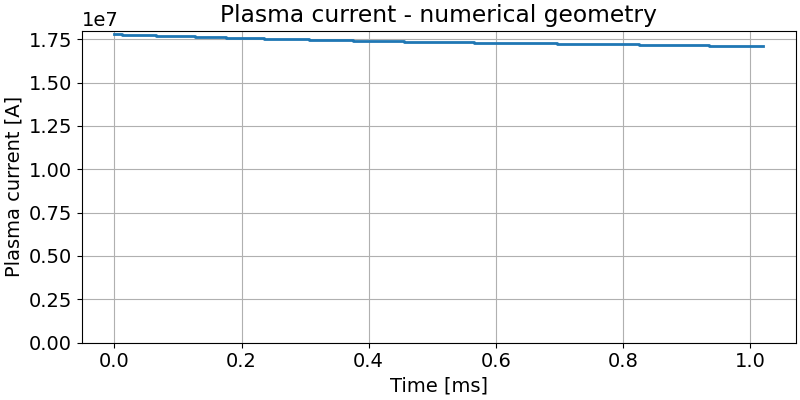

In [8]:
hdfkey = "eqsys/I_p"
timearr = np.empty(numoffiles, dtype=np.ndarray)
dataarr = np.empty(numoffiles, dtype=np.ndarray)
t = 0.0
for i in range(numoffiles):
    f = h5py.File(fnames[i], "r")
    timearr[i] = f["grid/t"][()] + t
    t = timearr[i][-1]
    dataarr[i] = f[hdfkey][()]

temptime = timearr[0]
tempdata = dataarr[0]

for i in (range(numoffiles - 1)):
    try:
        temptime = np.concatenate((temptime[:-1], timearr[i+1]))
        tempdata = np.concatenate((tempdata[:-1], dataarr[i+1]))
    except:
        print("Concatenation failed. Maybe only 1 file in fnames?")

ydata = tempdata
xdata = temptime * 1000  # to get milliseconds

basic_1D(figsize=[8,4], ydata=ydata, xdata=xdata, 
         ylabel="Plasma current [A]", xlabel="Time [ms]", 
         title="Plasma current - numerical geometry", yscale="linear", 
         ymin=0, ymax=18e6, savename=None, plotfoldername=plotfoldername1)

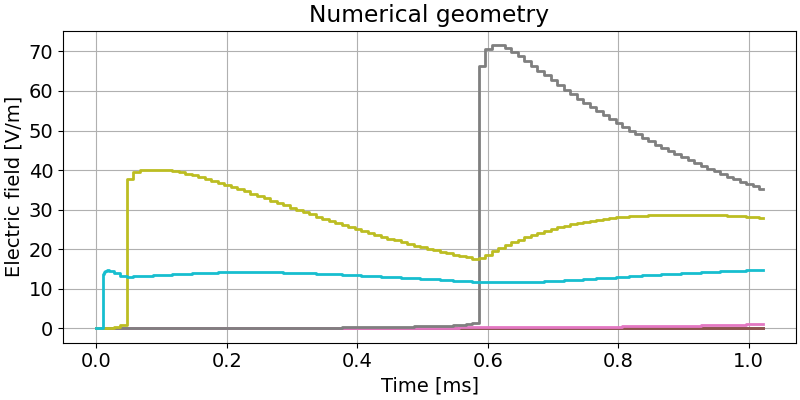

In [9]:
timearr = np.empty(numoffiles, dtype=np.ndarray)
dataarr = np.empty(numoffiles, dtype=np.ndarray)
t = 0.0
for i in range(numoffiles):
    f = h5py.File(fnames[i], "r")
    do = DREAMOutput(fnames[i])
    timearr[i] = f["grid/t"][()] + t
    t = timearr[i][-1]
    dataarr[i] = do.eqsys.E_field.getData()

temptime = timearr[0]
tempdata = dataarr[0]

for i in (range(numoffiles - 1)):
    try:
        temptime = np.concatenate((temptime[:-1], timearr[i+1]))
        tempdata = np.concatenate((tempdata[:-1], dataarr[i+1]))
    except:
        print("Concatenation failed. Maybe only 1 file in fnames?")

ydata = tempdata
xdata = temptime * 1000  # to get milliseconds

basic_1D(figsize=[8,4], ydata=ydata, xdata=xdata, 
         ylabel="Electric field [V/m]", xlabel="Time [ms]", 
         title="Numerical geometry", yscale="linear", 
         ymin=None, ymax=None, savename=None, plotfoldername=plotfoldername1)

(10,)
(171, 10)
(10,)
(171, 10)


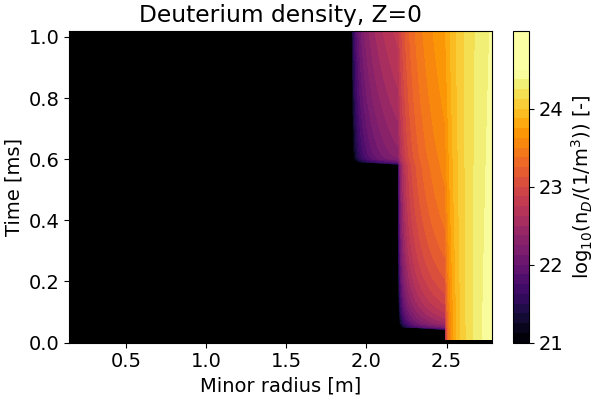

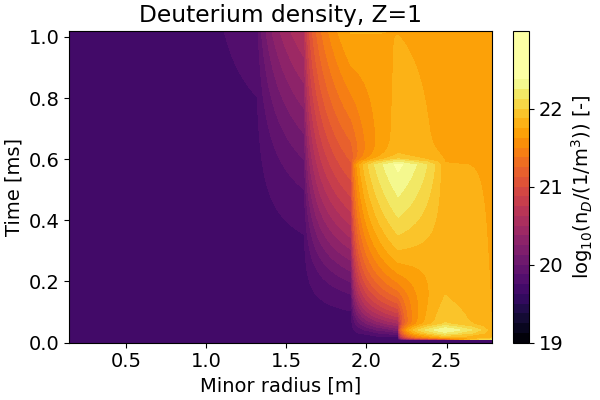

In [12]:
numoffiles = len(dos)
timearr = np.empty(numoffiles, dtype=np.ndarray)
dataarr = np.empty(numoffiles, dtype=np.ndarray)
t = 0.0
Z = 0
for i in range(numoffiles):
    timearr[i] = dos[i].grid.t[:] + t
    t = timearr[i][-1]
    dataarr[i] = dos[i].eqsys.n_i['D'].data[:,Z,:]

temptime = timearr[0]
tempdata = dataarr[0]

for i in (range(numoffiles - 1)):
    try:
        temptime = np.concatenate((temptime[:-1], timearr[i+1]))
        tempdata = np.concatenate((tempdata[:-1], dataarr[i+1]))
    except:
        print("Concatenation failed. Maybe only 1 file in fnames?")

data = tempdata
ygrid = temptime * 1000  # to get milliseconds
xgrid = f["grid/r"][()]

print(xgrid.shape)
print(data.shape)
# r"log$_{10}$(j$_{re}$/(1A/m$^2$)) [-]"
basic_2D(figsize=[6,4], xgrid=xgrid, ygrid=ygrid, savename=None, 
         title="Deuterium density, Z=" + str(Z),
         cbarlabel=r"log$_{10}$(n$_{D}$/(1/m$^3$)) [-]", plotfoldername=plotfoldername1,
         normalization="log", data=data, xlabel="Minor radius [m]", ylabel="Time [ms]",
         datamin=None, datamax=None, logdiff=4, levels=33)

numoffiles = len(dos)
timearr = np.empty(numoffiles, dtype=np.ndarray)
dataarr = np.empty(numoffiles, dtype=np.ndarray)
t = 0.0
Z = 1
for i in range(numoffiles):
    timearr[i] = dos[i].grid.t[:] + t
    t = timearr[i][-1]
    dataarr[i] = dos[i].eqsys.n_i['D'].data[:,Z,:]

temptime = timearr[0]
tempdata = dataarr[0]

for i in (range(numoffiles - 1)):
    try:
        temptime = np.concatenate((temptime[:-1], timearr[i+1]))
        tempdata = np.concatenate((tempdata[:-1], dataarr[i+1]))
    except:
        print("Concatenation failed. Maybe only 1 file in fnames?")

data = tempdata
ygrid = temptime * 1000  # to get milliseconds
xgrid = f["grid/r"][()]

print(xgrid.shape)
print(data.shape)
# r"log$_{10}$(j$_{re}$/(1A/m$^2$)) [-]"
basic_2D(figsize=[6,4], xgrid=xgrid, ygrid=ygrid, savename=None, 
         title="Deuterium density, Z=" + str(Z),
         cbarlabel=r"log$_{10}$(n$_{D}$/(1/m$^3$)) [-]", plotfoldername=plotfoldername1,
         normalization="log", data=data, xlabel="Minor radius [m]", ylabel="Time [ms]",
         datamin=None, datamax=None, logdiff=4, levels=33)

#plt2 = dos[-1].eqsys.n_i.getIonByName('D').plotSum(log=True)

(10,)
(171, 10)


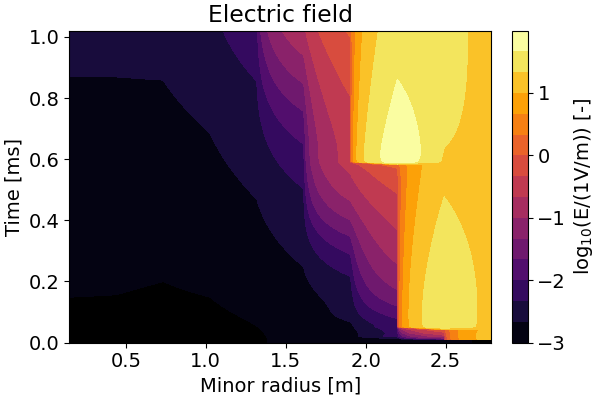

In [17]:
numoffiles = len(dos)
timearr = np.empty(numoffiles, dtype=np.ndarray)
dataarr = np.empty(numoffiles, dtype=np.ndarray)
t = 0.0
Z = 0
for i in range(numoffiles):
    timearr[i] = dos[i].grid.t[:] + t
    t = timearr[i][-1]
    dataarr[i] = dos[i].eqsys.E_field.getData()

temptime = timearr[0]
tempdata = dataarr[0]

for i in (range(numoffiles - 1)):
    try:
        temptime = np.concatenate((temptime[:-1], timearr[i+1]))
        tempdata = np.concatenate((tempdata[:-1], dataarr[i+1]))
    except:
        print("Concatenation failed. Maybe only 1 file in fnames?")

data = tempdata
ygrid = temptime * 1000  # to get milliseconds
xgrid = f["grid/r"][()]

print(xgrid.shape)
print(data.shape)
# r"log$_{10}$(j$_{re}$/(1A/m$^2$)) [-]"
logdiff = 5
n = 3
basic_2D(figsize=[6,4], xgrid=xgrid, ygrid=ygrid, savename=None, 
         title="Electric field",
         cbarlabel=r"log$_{10}$(E/(1V/m)) [-]", plotfoldername=plotfoldername1,
         normalization="log", data=data, xlabel="Minor radius [m]", ylabel="Time [ms]",
         datamin=None, datamax=None, logdiff=logdiff, levels=(n * logdiff) + 1)

(10,)
(171, 10)


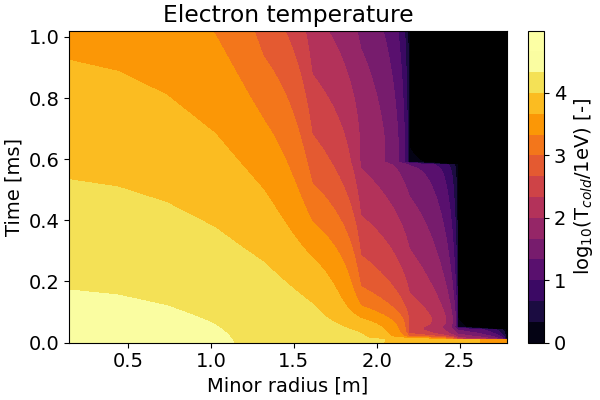

In [14]:
numoffiles = len(dos)
timearr = np.empty(numoffiles, dtype=np.ndarray)
dataarr = np.empty(numoffiles, dtype=np.ndarray)
t = 0.0
Z = 0
for i in range(numoffiles):
    timearr[i] = dos[i].grid.t[:] + t
    t = timearr[i][-1]
    dataarr[i] = dos[i].eqsys.T_cold.getData()

temptime = timearr[0]
tempdata = dataarr[0]

for i in (range(numoffiles - 1)):
    try:
        temptime = np.concatenate((temptime[:-1], timearr[i+1]))
        tempdata = np.concatenate((tempdata[:-1], dataarr[i+1]))
    except:
        print("Concatenation failed. Maybe only 1 file in fnames?")

data = tempdata
ygrid = temptime * 1000  # to get milliseconds
xgrid = f["grid/r"][()]

print(xgrid.shape)
print(data.shape)
# r"log$_{10}$(j$_{re}$/(1A/m$^2$)) [-]"
logdiff = 5
n = 3
basic_2D(figsize=[6,4], xgrid=xgrid, ygrid=ygrid, savename=None, 
         title="Electron temperature",
         cbarlabel=r"log$_{10}$(T$_{cold}$/1eV) [-]", plotfoldername=plotfoldername1,
         normalization="log", data=data, xlabel="Minor radius [m]", ylabel="Time [ms]",
         datamin=None, datamax=None, logdiff=logdiff, levels=(n * logdiff) + 1)

(10,)
(171, 10)


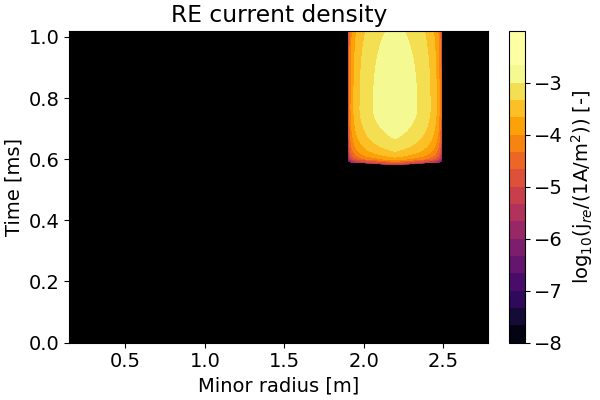

In [15]:
numoffiles = len(dos)
timearr = np.empty(numoffiles, dtype=np.ndarray)
dataarr = np.empty(numoffiles, dtype=np.ndarray)
t = 0.0
Z = 0
for i in range(numoffiles):
    timearr[i] = dos[i].grid.t[:] + t
    t = timearr[i][-1]
    dataarr[i] = dos[i].eqsys.j_re.getData()

temptime = timearr[0]
tempdata = dataarr[0]

for i in (range(numoffiles - 1)):
    try:
        temptime = np.concatenate((temptime[:-1], timearr[i+1]))
        tempdata = np.concatenate((tempdata[:-1], dataarr[i+1]))
    except:
        print("Concatenation failed. Maybe only 1 file in fnames?")

data = tempdata
ygrid = temptime * 1000  # to get milliseconds
xgrid = f["grid/r"][()]

print(xgrid.shape)
print(data.shape)
# r"log$_{10}$(j$_{re}$/(1A/m$^2$)) [-]"
logdiff = 6
n = 3
basic_2D(figsize=[6,4], xgrid=xgrid, ygrid=ygrid, savename=None, 
         title="RE current density",
         cbarlabel=r"log$_{10}$(j$_{re}$/(1A/m$^2$)) [-]", plotfoldername=plotfoldername1,
         normalization="log", data=data, xlabel="Minor radius [m]", ylabel="Time [ms]",
         datamin=None, datamax=None, logdiff=logdiff, levels=(n * logdiff) + 1)

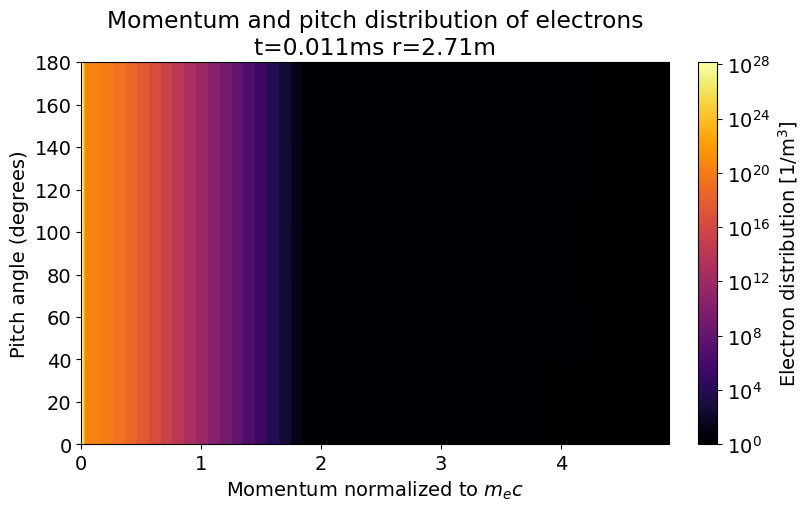

In [18]:
data = cdos[-1]
data.plot_2D_momentum(at_radial_cell=-2, at_timestep=0, from_momentum_cell=0, to_momentum_cell=-1, save=False,
                     ymin=None, ymax=None)

In [18]:
# 2D animated hottail distribution
# settings
data = cdos[-1]
figsize=[10, 5] 
at_timestep=0
at_radial_cell=-2
ymax=None
from_momentum_cell=0
to_momentum_cell=-1

fig = plt.figure(figsize=figsize)
data_to_plot = data.distribution_t_r_xi_p[0][at_timestep, at_radial_cell, :, from_momentum_cell:to_momentum_cell]

if data_to_plot.min() < 1.0:
    vmin = 1.0
else:
    vmin = data_to_plot.min()

im = plt.pcolormesh(data.momentumgrid_edges[from_momentum_cell:to_momentum_cell], data.pitchgrid_degrees_edges,
                    data_to_plot, norm=colors.LogNorm(vmin=vmin, vmax=data_to_plot.max()))
axes = plt.gca()
axes.set_facecolor('black')
axes.set_yticks(data.pitchgrid_degrees_edges, minor=False)
axes.set_axisbelow(False)
axes.yaxis.grid(True, which='major', linestyle="--")
axes.tick_params(axis='y', which='major', bottom=False)

fig.colorbar(im, ax=axes, label=r"Electron distribution [1/m$^3$]")
plt.title("Momentum and pitch distribution of electrons\nt=" 
          + '{0:.2f}'.format(np.round(data.timegrid_ms[at_timestep], 3))
          + "ms r=" + str(np.round(data.radialgrid[at_radial_cell], 3)) + "m")
plt.ylabel("Pitch angle (degrees)")
plt.xlabel(r"Momentum normalized to $m_ec$")

# creating a plot
#data_to_plot = data[at_timestep, radial_cell, :, from_momentum:to_momentum]
plotted = [plt.pcolormesh(data.momentumgrid_edges[from_momentum_cell:to_momentum_cell], data.pitchgrid_degrees_edges,
                          data_to_plot, norm=colors.LogNorm(vmin=vmin, vmax=data_to_plot.max()))]


def AnimationFunction(frame):
    frame = frame + at_timestep  # frame + index of starting timestep
    data_to_plot = data.distribution_t_r_xi_p[0][frame, at_radial_cell, :, from_momentum_cell:to_momentum_cell]
    plt.clf()
    plotted[0] = plt.pcolormesh(data.momentumgrid_edges[from_momentum_cell:to_momentum_cell], data.pitchgrid_degrees_edges,
                                data_to_plot, norm=colors.LogNorm(vmin=vmin, vmax=data_to_plot.max()))
    axes = plt.gca()
    axes.set_facecolor('black')
    axes.set_yticks(data.pitchgrid_degrees_edges, minor=False)
    axes.set_axisbelow(False)
    axes.yaxis.grid(True, which='major', linestyle="--")
    axes.tick_params(axis='y', which='major', bottom=False)
    axes.set_xlim(data.momentumgrid[from_momentum_cell], data.momentumgrid[to_momentum_cell - 1])
    fig.colorbar(plotted[0], ax=axes, label=r"Electron distribution [1/m$^3$]")
    plt.title("Momentum and pitch distribution of electrons\nt=" 
              + '{0:.6f}'.format(np.round(data.timegrid_ms[frame], 6))
              + "ms r=" + str(np.round(data.radialgrid[at_radial_cell], 3)) + "m")
    plt.ylabel(r"Pitch angle [degrees]")
    plt.xlabel(r"Momentum normalized to $m_ec$")


# Here the frames=... will give the length of the animation in number of timesteps
anim_created = FuncAnimation(fig, AnimationFunction, frames=len(data.timegrid), interval=200)    
video = anim_created.to_html5_video()
html = display.HTML(video)
display.display(html)

# good practice to close the plt object.
plt.close()

In [8]:
# 1D animated RE distribution
# settings
data = cdos[-1]
figsize=[10, 5] 
at_timestep=0
at_radial_cell=10
ymin=None
ymax=None
from_momentum_cell=0
to_momentum_cell=-1

fig = plt.figure(figsize=figsize)
data_to_plot = data.re_distribution_t_r_xi_p[0][at_timestep, at_radial_cell, 0, from_momentum_cell:to_momentum_cell]
dataend = data.re_distribution_t_r_xi_p[0][-1, at_radial_cell, 0, from_momentum_cell:to_momentum_cell]
#print(dataend.shape)
maxdata = dataend.max()

if data_to_plot.min() < 1.0:
    vmin = 1.0
else:
    vmin = data_to_plot.min()

im = plt.plot(data.re_momentumgrid[from_momentum_cell:to_momentum_cell], data_to_plot)
axes = plt.gca()
#axes.set_ylim(0, None)
axes.yaxis.grid(True, which='major', linestyle="--")
plt.title("Momentum distribution of runaway electrons\nt=" 
          + '{0:.3f}'.format(np.round(data.timegrid_ms[at_timestep], 3))
          + "ms r=" + str(np.round(data.radialgrid[at_radial_cell], 3)) + "m")
plt.ylabel(r"Electron distribution [1/m$^3$]")
plt.xlabel(r"Momentum normalized to $m_ec$")

# creating a plot
plotted = [plt.plot(data.re_momentumgrid[from_momentum_cell:to_momentum_cell], data_to_plot)]


def AnimationFunction(frame):
    frame = frame + at_timestep  # frame + index of starting timestep
    data_to_plot = data.re_distribution_t_r_xi_p[0][frame, at_radial_cell, 0, from_momentum_cell:to_momentum_cell]
    plt.clf()
    plotted[0] = plt.plot(data.re_momentumgrid[from_momentum_cell:to_momentum_cell], data_to_plot)
    axes = plt.gca()
    axes.yaxis.grid(True, which='major', linestyle="--")
    #axes.set_ylim(0, None)
    axes.set_xlim(data.re_momentumgrid[from_momentum_cell], data.re_momentumgrid[to_momentum_cell - 1])
    plt.title("Momentum distribution of runaway electrons\nt=" 
              + '{0:.3f}'.format(np.round(data.timegrid_ms[frame], 3))
              + "ms r=" + str(np.round(data.radialgrid[at_radial_cell], 3)) + "m")
    plt.ylabel(r"Electron distribution [1/m$^3$]")
    plt.xlabel(r"Momentum normalized to $m_ec$")


# Here the frames=... will give the length of the animation in number of timesteps
anim_created = FuncAnimation(fig, AnimationFunction, frames=int((len(data.timegrid) - at_timestep)/1), interval=200)    
video = anim_created.to_html5_video()
html = display.HTML(video)
display.display(html)

# good practice to close the plt object.
plt.close()

In [44]:
# 2D animated runaway distribution
# settings
# data = CDO.CustomDREAMOutput(root + folder1 + "output_2_.h5", 0.0)
data = cdos[-1]
figsize=[10, 5] 
at_timestep=0
at_radial_cell=6
ymin=None
ymax=None
from_momentum_cell=0
to_momentum_cell=50
save=False

fig = plt.figure(figsize=figsize)
data_to_plot = data.re_distribution_t_r_xi_p[0][at_timestep, at_radial_cell, :, from_momentum_cell:to_momentum_cell]
#data_to_plot = abs(data_to_plot)
#print(data.re_distribution_t_r_xi_p[0][:, at_radial_cell, :, from_momentum_cell:to_momentum_cell].max())
#print(data.re_distribution_t_r_xi_p[0][:, at_radial_cell, :, from_momentum_cell:to_momentum_cell].min())
if data_to_plot.min() < 1e-1:
    vmin = 1e-1
else:
    vmin = data_to_plot.min()


im = plt.pcolormesh(data.re_momentumgrid_edges[from_momentum_cell:to_momentum_cell], data.re_pitchgrid_degrees_edges,
                    data_to_plot[:,:-1], norm=colors.LogNorm(vmin=vmin, vmax=data_to_plot.max()))
axes = plt.gca()
axes.set_facecolor('black')
axes.set_yticks(data.re_pitchgrid_degrees_edges, minor=False)
axes.set_axisbelow(False)
axes.yaxis.grid(True, which='major', linestyle="--")
axes.tick_params(axis='y', which='major', bottom=False)

fig.colorbar(im, ax=axes, label=r"Electron distribution [1/m$^3$]")
plt.title("Momentum and pitch distribution of electrons\nt=" 
          + '{0:.2f}'.format(np.round(data.timegrid_ms[at_timestep], 3))
          + "ms r=" + str(np.round(data.radialgrid[at_radial_cell], 3)) + "m")
plt.ylabel("Pitch angle (degrees)")
plt.xlabel(r"Momentum normalized to $m_ec$")

# creating a plot
#data_to_plot = data[at_timestep, radial_cell, :, from_momentum:to_momentum]
plotted = [plt.pcolormesh(data.re_momentumgrid_edges[from_momentum_cell:to_momentum_cell], data.re_pitchgrid_degrees_edges,
                          data_to_plot[:,:-1], norm=colors.LogNorm(vmin=vmin, vmax=data_to_plot.max()))]


def AnimationFunction(frame):
    frame = frame + at_timestep  # frame + index of starting timestep
    data_to_plot = data.re_distribution_t_r_xi_p[0][frame, at_radial_cell, :, from_momentum_cell:to_momentum_cell]
    #data_to_plot = abs(data_to_plot)
    if data_to_plot.min() < 1e-1:
        vmin = 1e-1
    else:
        vmin = data_to_plot.min()
        
    plt.clf()
    plotted[0] = plt.pcolormesh(data.re_momentumgrid_edges[from_momentum_cell:to_momentum_cell], data.re_pitchgrid_degrees_edges,
                                data_to_plot[:,:-1], norm=colors.LogNorm(vmin=vmin, vmax=data_to_plot.max()))
    axes = plt.gca()
    axes.set_facecolor('black')
    axes.set_yticks(data.re_pitchgrid_degrees_edges, minor=False)
    axes.set_axisbelow(False)
    axes.yaxis.grid(True, which='major', linestyle="--")
    axes.tick_params(axis='y', which='major', bottom=False)
    axes.set_xlim(data.re_momentumgrid[from_momentum_cell], data.re_momentumgrid[to_momentum_cell - 1])
    fig.colorbar(plotted[0], ax=axes, label=r"Electron distribution [1/m$^3$]")
    plt.title("Momentum and pitch distribution of electrons\nt=" 
              + '{0:.2f}'.format(np.round(data.timegrid_ms[frame], 3))
              + "ms r=" + str(np.round(data.radialgrid[at_radial_cell], 3)) + "m")
    plt.ylabel(r"Pitch angle [degrees]")
    plt.xlabel(r"Momentum normalized to $m_ec$")


# Here the frames=... will give the length of the animation in number of timesteps
anim_created = FuncAnimation(fig, AnimationFunction, frames=len(data.timegrid), interval=250)    
video = anim_created.to_html5_video()
html = display.HTML(video)
display.display(html)

# good practice to close the plt object.
plt.close()

In [33]:
# 2D animated runaway distribution
# settings
data = cdos[-1]
figsize=[10, 5] 
at_timestep=0
at_radial_cell=10
ymin=None
ymax=None
from_momentum_cell=0
to_momentum_cell=60

fig = plt.figure(figsize=figsize)
data_to_plot = data.re_distribution_t_r_xi_p[0][at_timestep, at_radial_cell, :, from_momentum_cell:to_momentum_cell]
if data_to_plot.min() < 1e-1:
    vmin = 1e-1
else:
    vmin = data_to_plot.min()


im = plt.pcolormesh(data.re_momentumgrid_edges[from_momentum_cell:to_momentum_cell], data.re_pitchgrid_degrees_edges,
                    data_to_plot[:,:-1], norm=colors.LogNorm(vmin=vmin, vmax=data_to_plot.max()))
axes = plt.gca()
axes.set_facecolor('black')
axes.set_yticks(data.re_pitchgrid_degrees_edges, minor=False)
axes.set_axisbelow(False)
axes.yaxis.grid(True, which='major', linestyle="--")
axes.tick_params(axis='y', which='major', bottom=False)

fig.colorbar(im, ax=axes, label=r"Electron distribution [1/m$^3$]")
plt.title("Momentum and pitch distribution of electrons\nt=" 
          + '{0:.2f}'.format(np.round(data.timegrid_ms[at_timestep], 3))
          + "ms r=" + str(np.round(data.radialgrid[at_radial_cell], 3)) + "m")
plt.ylabel("Pitch angle (degrees)")
plt.xlabel(r"Momentum normalized to $m_ec$")

# creating a plot
#data_to_plot = data[at_timestep, radial_cell, :, from_momentum:to_momentum]
plotted = [plt.pcolormesh(data.re_momentumgrid_edges[from_momentum_cell:to_momentum_cell], data.re_pitchgrid_degrees_edges,
                          data_to_plot[:,:-1], norm=colors.LogNorm(vmin=vmin, vmax=data_to_plot.max()))]


def AnimationFunction(frame):
    frame = frame + at_timestep  # frame + index of starting timestep
    data_to_plot = data.re_distribution_t_r_xi_p[0][frame * 20, at_radial_cell, :, from_momentum_cell:to_momentum_cell]
    if data_to_plot.min() < 1e-1:
        vmin = 1e-1
    else:
        vmin = data_to_plot.min()
        
    plt.clf()
    plotted[0] = plt.pcolormesh(data.re_momentumgrid_edges[from_momentum_cell:to_momentum_cell], data.re_pitchgrid_degrees_edges,
                                data_to_plot[:,:-1], norm=colors.LogNorm(vmin=vmin, vmax=data_to_plot.max()))
    axes = plt.gca()
    axes.set_facecolor('black')
    axes.set_yticks(data.re_pitchgrid_degrees_edges, minor=False)
    axes.set_axisbelow(False)
    axes.yaxis.grid(True, which='major', linestyle="--")
    axes.tick_params(axis='y', which='major', bottom=False)
    axes.set_xlim(data.re_momentumgrid[from_momentum_cell], data.re_momentumgrid[to_momentum_cell - 1])
    fig.colorbar(plotted[0], ax=axes, label=r"Electron distribution [1/m$^3$]")
    plt.title("Momentum and pitch distribution of electrons\nt=" 
              + '{0:.2f}'.format(np.round(data.timegrid_ms[frame * 20], 3))
              + "ms r=" + str(np.round(data.radialgrid[at_radial_cell], 3)) + "m")
    plt.ylabel(r"Pitch angle [degrees]")
    plt.xlabel(r"Momentum normalized to $m_ec$")


# Here the frames=... will give the length of the animation in number of timesteps
anim_created = FuncAnimation(fig, AnimationFunction, frames=int(len(data.timegrid) / 20) + 1, interval=1000)    
video = anim_created.to_html5_video()
html = display.HTML(video)
display.display(html)

# good practice to close the plt object.
plt.close()

In [24]:
# 2D animated runaway distribution
# settings
data = cdos[-1]
figsize=[10, 5] 
at_timestep=0
at_radial_cell=3
ymin=None
ymax=None
from_momentum_cell=0
to_momentum_cell=-1
t0 = 0

fig = plt.figure(figsize=figsize)
data_to_plot = data.re_distribution_t_r_xi_p[0][at_timestep, at_radial_cell, :, from_momentum_cell:to_momentum_cell]
#print(data.re_distribution_t_r_xi_p[0][:, at_radial_cell, :, from_momentum_cell:to_momentum_cell].max())
#print(data.re_distribution_t_r_xi_p[0][:, at_radial_cell, :, from_momentum_cell:to_momentum_cell].min())
if data_to_plot.min() < 1e-1:
    vmin = 1e-1
else:
    vmin = data_to_plot.min()


im = plt.pcolormesh(data.re_energy_grid_electronvolts[from_momentum_cell:to_momentum_cell], data.re_pitchgrid_degrees,
                    data_to_plot, norm=colors.LogNorm(vmin=vmin, vmax=data_to_plot.max()))
axes = plt.gca()
axes.set_facecolor('black')
#axes.set_yticks(data.re_pitchgrid_degrees_edges, minor=False)
axes.set_axisbelow(False)
#axes.yaxis.grid(True, which='major', linestyle="--")
axes.tick_params(axis='y', which='major', bottom=False)

fig.colorbar(im, ax=axes, label=r"Electron distribution [1/m$^3$]")
plt.title("Momentum and pitch distribution of electrons\nt=" 
          + '{0:.2f}'.format(np.round(data.timegrid_ms[at_timestep] + t0, 3))
          + "ms r=" + str(np.round(data.radialgrid[at_radial_cell], 3)) + "m")
plt.ylabel("Pitch angle (degrees)")
plt.xlabel(r"Momentum normalized to $m_ec$")

# creating a plot
#data_to_plot = data[at_timestep, radial_cell, :, from_momentum:to_momentum]
plotted = [plt.pcolormesh(data.re_energy_grid_electronvolts[from_momentum_cell:to_momentum_cell], data.re_pitchgrid_degrees,
                          data_to_plot, norm=colors.LogNorm(vmin=vmin, vmax=data_to_plot.max()))]


def AnimationFunction(frame):
    frame = frame + at_timestep  # frame + index of starting timestep
    data_to_plot = data.re_distribution_t_r_xi_p[0][frame, at_radial_cell, :, from_momentum_cell:to_momentum_cell]
    if data_to_plot.min() < 1e-1:
        vmin = 1e-1
    else:
        vmin = data_to_plot.min()
        
    plt.clf()
    plotted[0] = plt.pcolormesh(data.re_energy_grid_electronvolts[from_momentum_cell:to_momentum_cell], data.re_pitchgrid_degrees,
                                data_to_plot, norm=colors.LogNorm(vmin=vmin, vmax=data_to_plot.max()))
    axes = plt.gca()
    axes.set_facecolor('black')
    #axes.set_yticks(data.re_pitchgrid_degrees_edges, minor=False)
    axes.set_axisbelow(False)
    #axes.yaxis.grid(True, which='major', linestyle="--")
    axes.tick_params(axis='y', which='major', bottom=False)
    axes.set_xlim(data.re_energy_grid_electronvolts[from_momentum_cell], data.re_energy_grid_electronvolts[to_momentum_cell - 1])
    fig.colorbar(plotted[0], ax=axes, label=r"Electron distribution [1/m$^3$]")
    plt.title("Energy and pitch distribution of electrons\nt=" 
              + '{0:.2f}'.format(np.round(data.timegrid_ms[frame] + t0, 3))
              + "ms r=" + str(np.round(data.radialgrid[at_radial_cell], 3)) + "m")
    plt.ylabel(r"Pitch angle [degrees]")
    plt.xlabel(r"Energy [eV]")


# Here the frames=... will give the length of the animation in number of timesteps
anim_created = FuncAnimation(fig, AnimationFunction, frames=int(len(data.timegrid)), interval=250)    
video = anim_created.to_html5_video()
html = display.HTML(video)
display.display(html)

# good practice to close the plt object.
plt.close()

In [68]:
# 2D animated hottail distribution
# settings
data = cdos[-1]
figsize=[10, 5] 
at_timestep=0
at_radial_cell=7
ymin=None
ymax=None
from_momentum_cell=0
to_momentum_cell=-1

fig = plt.figure(figsize=figsize)
data_to_plot = data.distribution_t_r_xi_p[0][at_timestep, at_radial_cell, :, from_momentum_cell:to_momentum_cell]

if data_to_plot.min() < 1.0:
    vmin = 1.0
else:
    vmin = data_to_plot.min()

im = plt.pcolormesh(data.momentumgrid_edges[from_momentum_cell:to_momentum_cell], data.pitchgrid_degrees_edges,
                    data_to_plot, norm=colors.LogNorm(vmin=vmin, vmax=data_to_plot.max()))
axes = plt.gca()
axes.set_facecolor('black')
axes.set_yticks(data.pitchgrid_degrees_edges, minor=False)
axes.set_axisbelow(False)
axes.yaxis.grid(True, which='major', linestyle="--")
axes.tick_params(axis='y', which='major', bottom=False)

fig.colorbar(im, ax=axes, label=r"Electron distribution [1/m$^3$]")
plt.title("Momentum and pitch distribution of electrons\nt=" 
          + '{0:.2f}'.format(np.round(data.timegrid_ms[at_timestep], 3))
          + "ms r=" + str(np.round(data.radialgrid[at_radial_cell], 3)) + "m")
plt.ylabel("Pitch angle (degrees)")
plt.xlabel(r"Momentum normalized to $m_ec$")

# creating a plot
#data_to_plot = data[at_timestep, radial_cell, :, from_momentum:to_momentum]
plotted = [plt.pcolormesh(data.momentumgrid_edges[from_momentum_cell:to_momentum_cell], data.pitchgrid_degrees_edges,
                          data_to_plot, norm=colors.LogNorm(vmin=vmin, vmax=data_to_plot.max()))]


def AnimationFunction(frame):
    frame = frame + at_timestep  # frame + index of starting timestep
    data_to_plot = data.distribution_t_r_xi_p[0][frame, at_radial_cell, :, from_momentum_cell:to_momentum_cell]
    plt.clf()
    plotted[0] = plt.pcolormesh(data.momentumgrid_edges[from_momentum_cell:to_momentum_cell], data.pitchgrid_degrees_edges,
                                data_to_plot, norm=colors.LogNorm(vmin=vmin, vmax=data_to_plot.max()))
    axes = plt.gca()
    axes.set_facecolor('black')
    axes.set_yticks(data.pitchgrid_degrees_edges, minor=False)
    axes.set_axisbelow(False)
    axes.yaxis.grid(True, which='major', linestyle="--")
    axes.tick_params(axis='y', which='major', bottom=False)
    axes.set_xlim(data.momentumgrid[from_momentum_cell], data.momentumgrid[to_momentum_cell - 1])
    fig.colorbar(plotted[0], ax=axes, label=r"Electron distribution [1/m$^3$]")
    plt.title("Momentum and pitch distribution of electrons\nt=" 
              + '{0:.6f}'.format(np.round(data.timegrid_ms[frame], 6))
              + "ms r=" + str(np.round(data.radialgrid[at_radial_cell], 3)) + "m")
    plt.ylabel(r"Pitch angle [degrees]")
    plt.xlabel(r"Momentum normalized to $m_ec$")


# Here the frames=... will give the length of the animation in number of timesteps
anim_created = FuncAnimation(fig, AnimationFunction, frames=len(data.timegrid), interval=500)    
video = anim_created.to_html5_video()
html = display.HTML(video)
display.display(html)

# good practice to close the plt object.
plt.close()

In [70]:
# 2D animated runaway distribution
# settings
data = cdos[-1]
figsize=[10, 5] 
at_timestep=0
at_radial_cell=7
ymin=None
ymax=None
from_momentum_cell=0
to_momentum_cell=20
t0 = 0

fig = plt.figure(figsize=figsize)
data_to_plot = data.re_distribution_t_r_xi_p[0][at_timestep, at_radial_cell, :, from_momentum_cell:to_momentum_cell]
#print(data.re_distribution_t_r_xi_p[0][:, at_radial_cell, :, from_momentum_cell:to_momentum_cell].max())
#print(data.re_distribution_t_r_xi_p[0][:, at_radial_cell, :, from_momentum_cell:to_momentum_cell].min())
if data_to_plot.min() < 1e-1:
    vmin = 1e-1
else:
    vmin = data_to_plot.min()


im = plt.pcolormesh(data.re_energy_grid_electronvolts[from_momentum_cell:to_momentum_cell], data.re_pitchgrid_degrees,
                    data_to_plot, norm=colors.LogNorm(vmin=vmin, vmax=data_to_plot.max()))
axes = plt.gca()
axes.set_facecolor('black')
#axes.set_yticks(data.re_pitchgrid_degrees_edges, minor=False)
axes.set_axisbelow(False)
#axes.yaxis.grid(True, which='major', linestyle="--")
axes.tick_params(axis='y', which='major', bottom=False)

fig.colorbar(im, ax=axes, label=r"Electron distribution [1/m$^3$]")
plt.title("Momentum and pitch distribution of electrons\nt=" 
          + '{0:.2f}'.format(np.round(data.timegrid_ms[at_timestep] + t0, 3))
          + "ms r=" + str(np.round(data.radialgrid[at_radial_cell], 3)) + "m")
plt.ylabel("Pitch angle (degrees)")
plt.xlabel(r"Momentum normalized to $m_ec$")

# creating a plot
#data_to_plot = data[at_timestep, radial_cell, :, from_momentum:to_momentum]
plotted = [plt.pcolormesh(data.re_energy_grid_electronvolts[from_momentum_cell:to_momentum_cell], data.re_pitchgrid_degrees,
                          data_to_plot, norm=colors.LogNorm(vmin=vmin, vmax=data_to_plot.max()))]


def AnimationFunction(frame):
    frame = frame + at_timestep  # frame + index of starting timestep
    data_to_plot = data.re_distribution_t_r_xi_p[0][frame, at_radial_cell, :, from_momentum_cell:to_momentum_cell]
    if data_to_plot.min() < 1e-1:
        vmin = 1e-1
    else:
        vmin = data_to_plot.min()
        
    plt.clf()
    plotted[0] = plt.pcolormesh(data.re_energy_grid_electronvolts[from_momentum_cell:to_momentum_cell], data.re_pitchgrid_degrees,
                                data_to_plot, norm=colors.LogNorm(vmin=vmin, vmax=data_to_plot.max()))
    axes = plt.gca()
    axes.set_facecolor('black')
    #axes.set_yticks(data.re_pitchgrid_degrees_edges, minor=False)
    axes.set_axisbelow(False)
    #axes.yaxis.grid(True, which='major', linestyle="--")
    axes.tick_params(axis='y', which='major', bottom=False)
    axes.set_xlim(data.re_energy_grid_electronvolts[from_momentum_cell], data.re_energy_grid_electronvolts[to_momentum_cell - 1])
    fig.colorbar(plotted[0], ax=axes, label=r"Electron distribution [1/m$^3$]")
    plt.title("Energy and pitch distribution of electrons\nt=" 
              + '{0:.2f}'.format(np.round(data.timegrid_ms[frame] + t0, 3))
              + "ms r=" + str(np.round(data.radialgrid[at_radial_cell], 3)) + "m")
    plt.ylabel(r"Pitch angle [degrees]")
    plt.xlabel(r"Energy [eV]")


# Here the frames=... will give the length of the animation in number of timesteps
anim_created = FuncAnimation(fig, AnimationFunction, frames=int(len(data.timegrid)), interval=500)    
video = anim_created.to_html5_video()
html = display.HTML(video)
display.display(html)

# good practice to close the plt object.
plt.close()

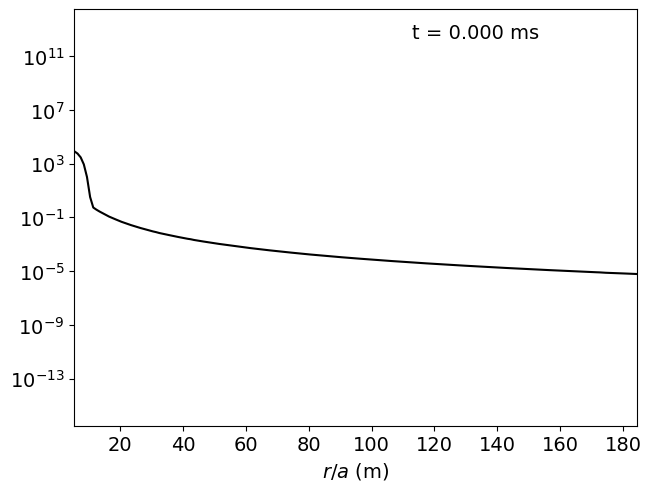

In [29]:
fa = dos[-1].eqsys.f_re.animate(r=4)
anim = fa.to_html5_video()
html = display.HTML(anim)
display.display(html)

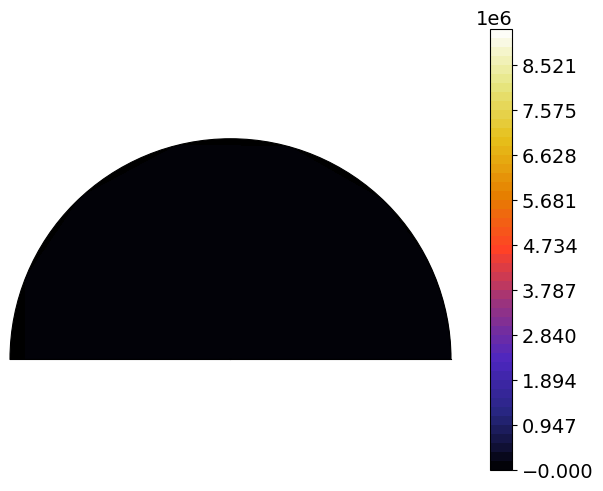

Help on NoneType object:

class NoneType(object)
 |  Methods defined here:
 |  
 |  __bool__(self, /)
 |      True if self else False
 |  
 |  __repr__(self, /)
 |      Return repr(self).
 |  
 |  ----------------------------------------------------------------------
 |  Static methods defined here:
 |  
 |  __new__(*args, **kwargs) from builtins.type
 |      Create and return a new object.  See help(type) for accurate signature.



In [25]:
help(dos[-1].eqsys.f_re.animatePolar())
